# (논문) STUDY
> Cat/Dog_accuracy / 이미지 위에 그림 그리기

- toc:true
- branch: master
- badges: true
- comments: true
- author: 김하영
- categories: [Study]

---

## **전체 이미지를 대상으로 $\theta$를 바꿔가며 accuracy 변화를 확인하자**

### import 

In [1]:
import torch 
from fastai.vision.all import *
import cv2

---

### data 

In [2]:
path=untar_data(URLs.PETS)/'images'

In [3]:
path

Path('/home/khy/.fastai/data/oxford-iiit-pet/images')

In [4]:
files=get_image_files(path)

In [5]:
def label_func(f):
    if f[0].isupper():
        return 'cat' 
    else: 
        return 'dog' 

In [6]:
dls=ImageDataLoaders.from_name_func(path,files,label_func,item_tfms=Resize(512)) 

---

### learn

In [7]:
lrnr=cnn_learner(dls,resnet34,metrics=error_rate)
lrnr.fine_tune(1)

In [8]:
net1=lrnr.model[0]
net2=lrnr.model[1] 

In [9]:
net2 = torch.nn.Sequential(
    torch.nn.AdaptiveAvgPool2d(output_size=1), 
    torch.nn.Flatten(),
    torch.nn.Linear(512,out_features=2,bias=False))

In [10]:
net=torch.nn.Sequential(net1,net2)

In [11]:
lrnr2=Learner(dls,net,metrics=accuracy) 

In [12]:
lrnr2.fine_tune(15) 

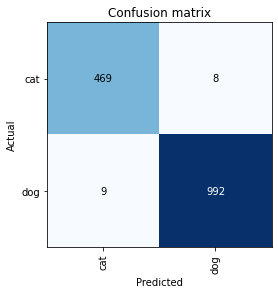

In [13]:
interp = ClassificationInterpretation.from_learner(lrnr2)
interp.plot_confusion_matrix()

In [14]:
interp = Interpretation.from_learner(lrnr2)

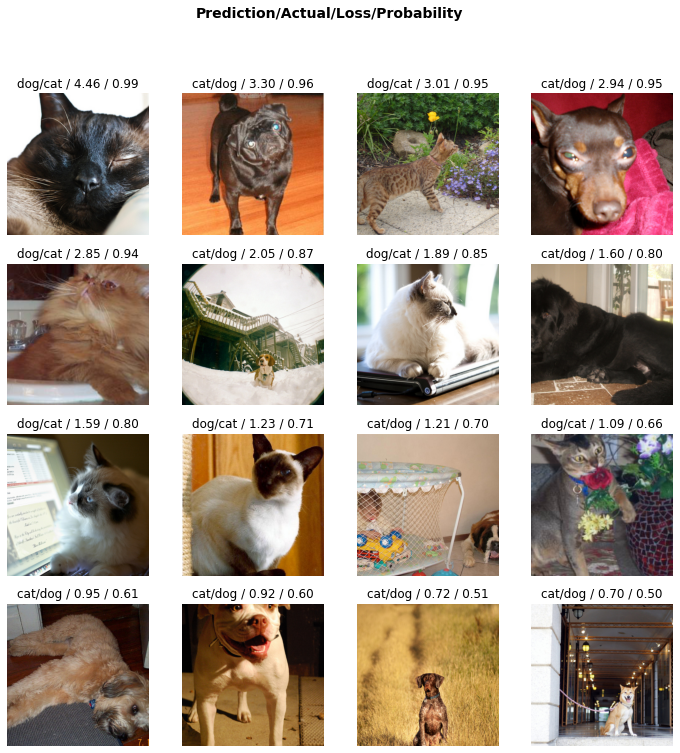

In [15]:
interp.plot_top_losses(16)

---

### $\theta=0.1$

#### 1st 

In [16]:
files

(#7390) [Path('/home/khy/.fastai/data/oxford-iiit-pet/images/boxer_128.jpg'),Path('/home/khy/.fastai/data/oxford-iiit-pet/images/Sphynx_142.jpg'),Path('/home/khy/.fastai/data/oxford-iiit-pet/images/British_Shorthair_203.jpg'),Path('/home/khy/.fastai/data/oxford-iiit-pet/images/Ragdoll_142.jpg'),Path('/home/khy/.fastai/data/oxford-iiit-pet/images/Persian_272.jpg'),Path('/home/khy/.fastai/data/oxford-iiit-pet/images/Bombay_200.jpg'),Path('/home/khy/.fastai/data/oxford-iiit-pet/images/shiba_inu_103.jpg'),Path('/home/khy/.fastai/data/oxford-iiit-pet/images/chihuahua_142.jpg'),Path('/home/khy/.fastai/data/oxford-iiit-pet/images/scottish_terrier_156.jpg'),Path('/home/khy/.fastai/data/oxford-iiit-pet/images/basset_hound_163.jpg')...]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

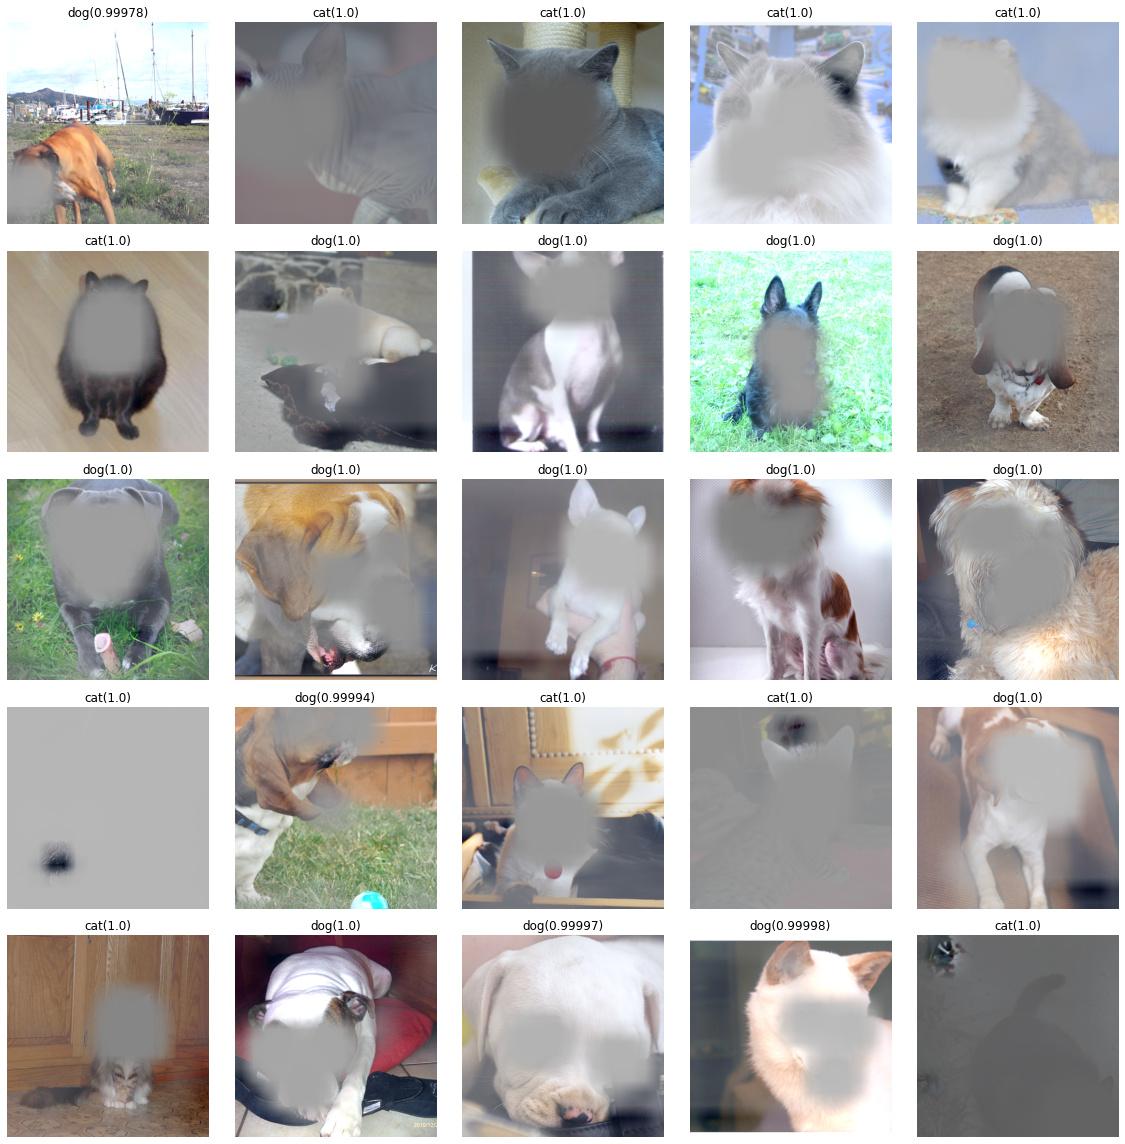

In [17]:
fig, ax = plt.subplots(5,5) 
k=0 
for i in range(5):
    for j in range(5): 
        x, = first(dls.test_dl([PILImage.create(get_image_files(path)[k])]))
        camimg = torch.einsum('ij,jkl -> ikl', net2[2].weight, net1(x).squeeze())
        a,b = net(x).tolist()[0]
        catprob, dogprob = np.exp(a)/ (np.exp(a)+np.exp(b)) ,  np.exp(b)/ (np.exp(a)+np.exp(b)) 
        if catprob>dogprob: 
            test=camimg[0]-torch.min(camimg[0])
            A1=torch.exp(-0.1*test)
            X1=np.array(A1.to("cpu").detach(),dtype=np.float32)
            Y1=torch.Tensor(cv2.resize(X1,(512,512),interpolation=cv2.INTER_LINEAR))
            x1=x.squeeze().to('cpu')*Y1-torch.min(x.squeeze().to('cpu')*Y1)
            (x1*0.35).squeeze().show(ax=ax[i][j])
            ax[i][j].set_title("cat(%s)" % catprob.round(5))
        else: 
            test=camimg[1]-torch.min(camimg[1])
            A1=torch.exp(-0.1*test)
            X1=np.array(A1.to("cpu").detach(),dtype=np.float32)
            Y1=torch.Tensor(cv2.resize(X1,(512,512),interpolation=cv2.INTER_LINEAR))
            x1=x.squeeze().to('cpu')*Y1-torch.min(x.squeeze().to('cpu')*Y1)
            (x1*0.35).squeeze().show(ax=ax[i][j])
            ax[i][j].set_title("dog(%s)" % dogprob.round(5))
        k=k+1 
fig.set_figwidth(16)            
fig.set_figheight(16)
fig.tight_layout()

In [23]:
img = PILImage.create(get_image_files(path)[3])
img
x, = first(dls.test_dl([img]))

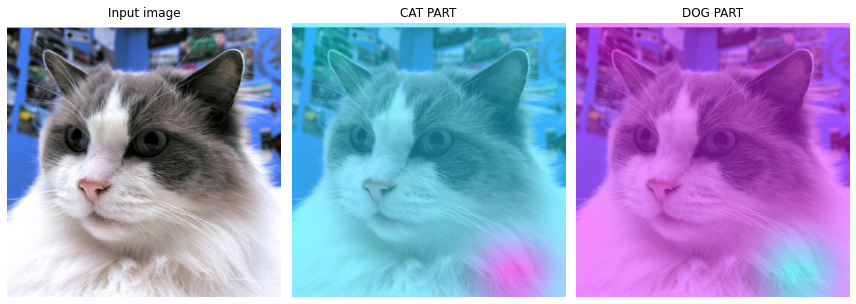

In [24]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3) 
# 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.set_title("Input image")
# 
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(camimg[0].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax2.set_title("CAT PART")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax3)
ax3.imshow(camimg[1].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax3.set_title("DOG PART")
#
fig.set_figwidth(12)            
fig.set_figheight(12)
fig.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

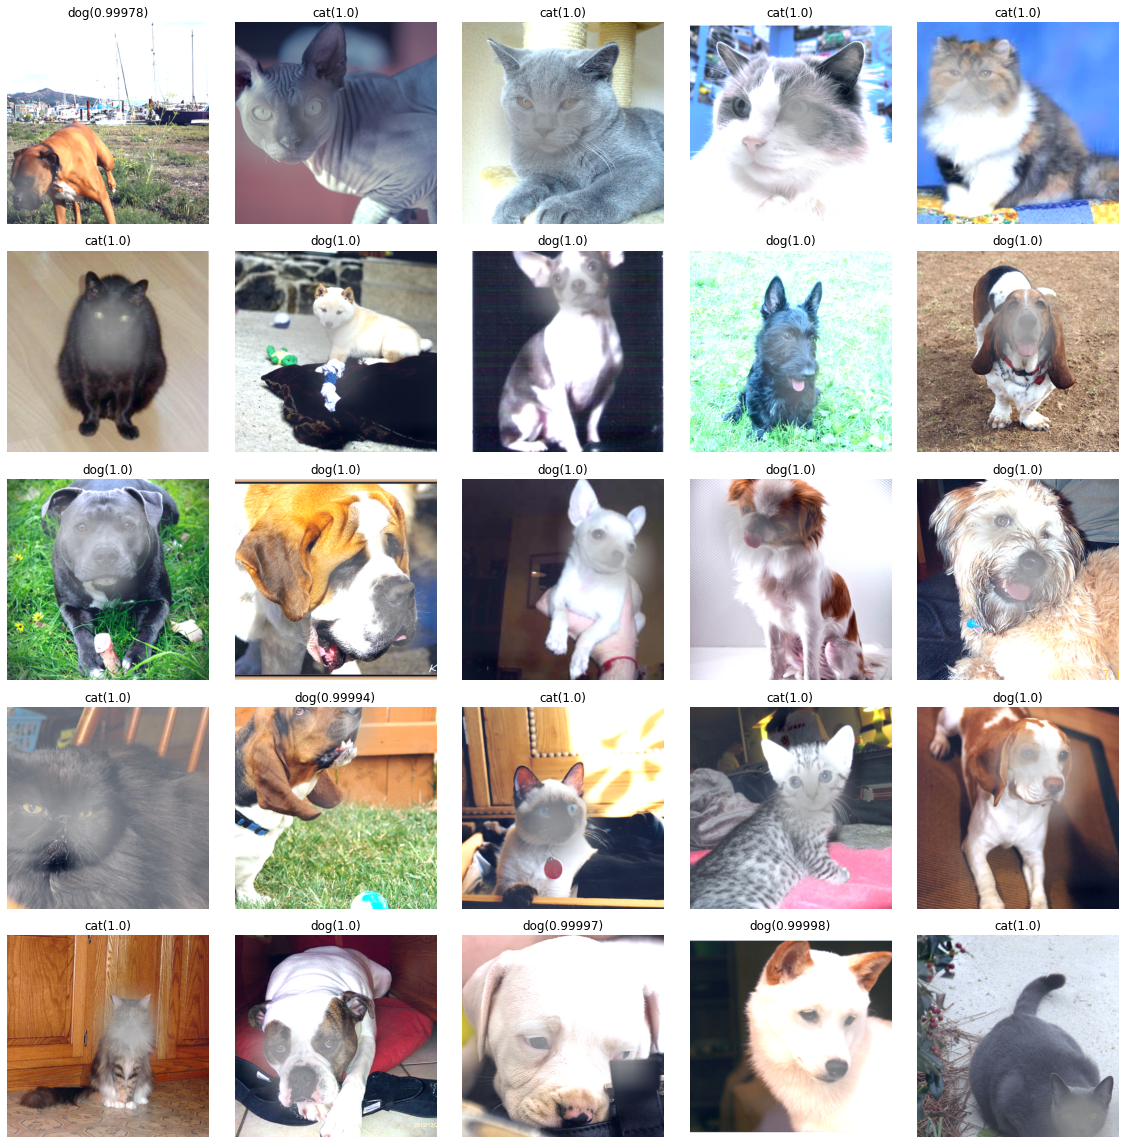

In [20]:
fig, ax = plt.subplots(5,5) 
k=0 
for i in range(5):
    for j in range(5): 
        x, = first(dls.test_dl([PILImage.create(get_image_files(path)[k])]))
        camimg = torch.einsum('ij,jkl -> ikl', net2[2].weight, net1(x).squeeze())
        a,b = net(x).tolist()[0]
        catprob, dogprob = np.exp(a)/ (np.exp(a)+np.exp(b)) ,  np.exp(b)/ (np.exp(a)+np.exp(b)) 
        if catprob>dogprob: 
            test=camimg[0]-torch.min(camimg[0])
            A1=torch.exp(-0.015*test)
            X1=np.array(A1.to("cpu").detach(),dtype=np.float32)
            Y1=torch.Tensor(cv2.resize(X1,(512,512),interpolation=cv2.INTER_LINEAR))
            x1=x.squeeze().to('cpu')*Y1-torch.min(x.squeeze().to('cpu')*Y1)
            (x1*0.35).squeeze().show(ax=ax[i][j])
            ax[i][j].set_title("cat(%s)" % catprob.round(5))
        else: 
            test=camimg[1]-torch.min(camimg[1])
            A1=torch.exp(-0.015*test)
            X1=np.array(A1.to("cpu").detach(),dtype=np.float32)
            Y1=torch.Tensor(cv2.resize(X1,(512,512),interpolation=cv2.INTER_LINEAR))
            x1=x.squeeze().to('cpu')*Y1-torch.min(x.squeeze().to('cpu')*Y1)
            (x1*0.35).squeeze().show(ax=ax[i][j])
            ax[i][j].set_title("dog(%s)" % dogprob.round(5))
        k=k+1 
fig.set_figwidth(16)            
fig.set_figheight(16)
fig.tight_layout()

----

## **이미지 위에 그림그리기**

ref.   
https://yunwoong.tistory.com/71  
https://nomalcy.tistory.com/34  
https://www.geeksforgeeks.org/python-pil-imagedraw-draw-rectangle/  
https://stackoverflow.com/questions/16373425/add-text-on-image-using-pil

In [166]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import ImageDraw
from PIL import ImageFont

### **SAMPLE**

In [203]:
get_image_files(path)[0]

Path('/home/khy/.fastai/data/oxford-iiit-pet/images/boxer_128.jpg')

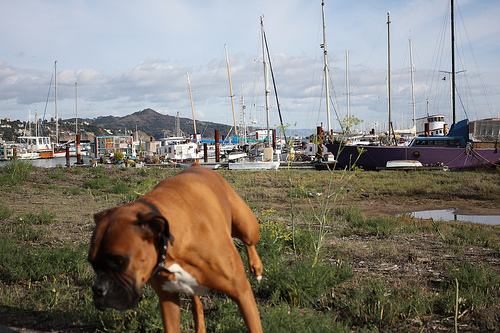

In [204]:
img = PILImage.create(get_image_files(path)[0])
img

In [160]:
x, = first(dls.test_dl([img]))

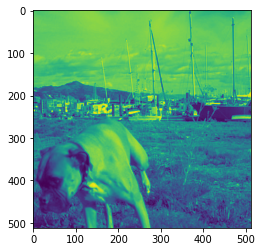

In [161]:
plt.imshow(x.squeeze().to('cpu')[0])
plt.show()

In [152]:
img.shape

(333, 500)

#### box넣기

In [205]:
w, h = 333, 500
shape = [(0, 0), (w - 150, h - 450)]

<AxesSubplot:>

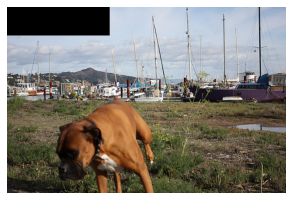

In [206]:
img1 = ImageDraw.Draw(img)  
img1.rectangle(shape, fill ="black", outline ="black")
img.show()

In [164]:
??draw.rectangle

Signature: draw.rectangle(xy, fill=None, outline=None, width=1)
Source:   
    def rectangle(self, xy, fill=None, outline=None, width=1):
        """Draw a rectangle."""
        ink, fill = self._getink(outline, fill)
        if fill is not None:
            self.draw.draw_rectangle(xy, fill, 1)
        if ink is not None and ink != fill and width != 0:
            self.draw.draw_rectangle(xy, ink, 0, width)
File:      ~/anaconda3/envs/bda2021/lib/python3.8/site-packages/PIL/ImageDraw.py
Type:      method


#### text넣기

In [207]:
font = ImageFont.truetype("DejaVuSans.ttf", 45)

<AxesSubplot:>

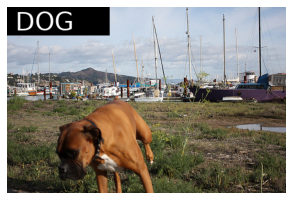

In [208]:
ImageDraw.Draw(img).text((15, 0), 'DOG', (255, 255, 255), font=font)
img.show()

### **전체 적용하기**